
# **Detekcija Lica na fotografijama**

Predmet: Principi prezentacije i prepoznavanja oblika

Student: Mladen Bajić IT46-2018

## Sadržaj
  

1.   *Uvod*
2.   *Zašto detekcija lica?*
3.   *Biblioteke*
4.   *Dataset*
5.   *Detekcija lica pomoću Viola Jones/Haar-like i Adaboost Cascade*
6.   *Detekcija lica pomoću HOG karakteristika*
7.   *Detekcija lica pomoću MTCNN*
8.   *Zaključak*
9.   *Reference*



## Uvod

Detekcija objekata je zadatak obrade fotografije ili video zapisa koji otkriva (semantičke) instance objekata koje odgovaraju datom tipu (npr. lica, ljudi, vozila i zgrade) na fotografijama.

Detekcija lica je podgrupa šire grupe(deteckije oblika).Prvo pitanje na koje detekcija lica treba da odgovori jeste da li postoji lice na izbranoj fotografiji ili video zapisu, te da ga označi ukoliko je to cilj. Naravno pored same detekcije lica možemo detektovati i ključne tačke na licu. Detekcija ključnih tački ili djelova značajna je i pri određivanje raspoloženja, godina i pola, ali ove aspekte nećemo previše obrađivati u nastavku rada. Klučne tačke ćemo minimalno obraditi u MTCNN metodi detekcije lica. Detekcija lica postala je veoma popularna poslenjih godina i ima veliku primjenu kako u sektoru bezbjednosti tako i u razvoju softvera. 

## Biblioteke

U nastavu se nalazi opis korišćenjih biblioteka.

 - ### Dlib
 Dlib je moderan C++ alat koji sadrži algoritme za mašinsko učenje i alate za kreiranje složenog softvera u C++ za rješavanje problema iz stvarnog svijeta. Koristi se u industriji i u akademskim krugovima u širokom spektru domena uključujući robotiku, embedded uređaje, mobilne telefone i velika računarska okruženja visokih performansi. Dlib-ovo licenciranje otvorenog koda omogućava vam da ga besplatno koristite u bilo kojoj aplikaciji.

 - ### OpenCV

 OpenCV je Python biblioteka koja je dizajnirana za rješavanje problema kompjuterske vizije. OpenCV je prvobitno razvijen 1999. od strane Intela, ali ga je kasnije podržala Willow Garage.
  OpenCV podržava širok spektar programskih jezika kao što su C++, Python, Java itd. Podrška za više platformi uključujući Windows, Linux i MacOS.
  OpenCV Python nije ništa drugo nego klasa omotača za originalnu C++ biblioteku koja se koristi sa Python-om. Koristeći ovo, sve strukture OpenCV niza se konvertuju u/iz NumPy nizova.
  Ovo olakšava njegovu integraciju sa drugim bibliotekama koje koriste NumPy. Na primjer, biblioteke kao što su SciPy i Matplotlib.

 - ### matplotlib.pyplot 
 matplotlib.pyplot je kolekcija funkcija koje čine da matplotlib radi kao MATLAB. Svaka funkcija pyplot unosi neku promjenu na figuru: npr. kreira figuru, kreira područje za crtanje na slici, iscrtava neke linije u području za crtanje, ukrašava dijagram oznakama, itd.

 - ### mtcnn 
 mtcnn je biblioteka za detekciju lica napisa od nule. Kao referencu koristila je implementaciju MTCNN-a iz rada Davida Sandberga. Više o ovoj biblioteci na https://github.com/ipazc/mtcnn

### Instaliranje i importovanje biblioteka

In [17]:
#instaliranje biblioteke koja nije default
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# importovanje neopho9dnih biblioteka
import os
import dlib
import cv2
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt


##Dataset

Dataset koji je korišćen u nastavku ovog projekta sastoji se of 274 fotografije sa licima poznatih glumaca prije svega iz marvelovih filmova. 

Glumci i broj slika:

1.   Chris Evans (50 fotografija)
2.   Chris Hemsworth (53 fotografije)
3.   Mark Ruffalo (66 fotografija)
4.   Robert DowneyJr (51 fotografijan)
5.   Scarlett Johansson (54 fotografije)

U nastavku se povezujemo na google drive i obzirom da se datoteke nalaze u različitim dirktorijumima, neophodno je da im promjenimo velilčinu i smjestimo ih sve u zajednički repozitorijum.

In [19]:
# konektovanje na drive
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Sledeći dio koda nam služi da prilagodimo dataset i pripremimo okruženje kako bi se u nastavku mogli fokusirati na primjenu modela.

In [20]:
def adjust_image_size(path): #metoda koja mjenja veličinu slike i smješta je novi direkrotijum
  files = os.listdir(path)
  new_location = "/content/drive/MyDrive/adjusted_images"
  for file in files:
    image = cv2.imread(path + "/" + file)
    adjusted = cv2.resize(image, (150, 150), interpolation = cv2.INTER_AREA)
    cv2.imwrite(new_location +"/"+ file, adjusted)

#poziv metode iznad za svaki poddirektorijum
adjust_image_size("/content/drive/MyDrive/cropped_images/chris_evans") 
adjust_image_size("/content/drive/MyDrive/cropped_images/chris_hemsworth")
adjust_image_size("/content/drive/MyDrive/cropped_images/mark_ruffalo")
adjust_image_size("/content/drive/MyDrive/cropped_images/robert_downey_jr")
adjust_image_size("/content/drive/MyDrive/cropped_images/scarlett_johansson")

#Uzimanje po jedne slike svakog glumca
evans_image = cv2.imread("/content/drive/MyDrive/adjusted_images/chris_evans5.png")
hemsworth_image = cv2.imread("/content/drive/MyDrive/adjusted_images/chris_hemsworth4.png")
mark_ruffalo = cv2.imread("/content/drive/MyDrive/adjusted_images/mark_ruffalo10.png")
robert_downey = cv2.imread("/content/drive/MyDrive/adjusted_images/robert_downey_jr36.png")
scarlett_johansson = cv2.imread("/content/drive/MyDrive/adjusted_images/scarlett_johansson29.png")
 
#Smještanje svih slika u niz koji koristimo dalje u svakom prilazu
images_array = [evans_image, hemsworth_image, mark_ruffalo, robert_downey, scarlett_johansson]


## Detekcija lica pomoću Viola Jones/Haar-like i Adaboost Cascade


**Haar-like** funkcije su vrlo korisne karakteristike fotografije koje se koriste u detekciji objekata.

**Viola i Jones** su ih uveli u prvi detektor lica u stvarnom vremenu. Korišćenjem integralnih fotografija, Haar-ove karakteristike bilo koje veličine (skale) mogu se efikasno izračunati u konstantnom vremenu.

**Viola Jones** je novi pristup brzoj detekciji objekata sa mogućnošću pokretanja od 15 sličica u sekundi. Bio je to prvi koji je postigao detekciju objekata u realnom vremenu.


Kao što se vidi iz primjera ispod za prepoznavanje prepoznavanje lica, očijiju i usana koristimo funciju detectMultiScale() sa različitom porthodno obučenom kaskadnim karakteristikama lica. U našem slučaju za prepoznavanje lica, očiju i usana koristimo: https://github.com/opencv/opencv/tree/master/data/haarcascades.

Ova funkcija prihvata sledeće parametre:

scaleFactor: Ovo je parametar koji određuje u kojoj meri se veličina fotografije smanjuje za svaku skalu fotografije i koristi za stvaranje piramide skale (npr. faktor skale od 1,2 znači smanjenje veličine za 20%). Što je manji parametar scaleFactor, to je veća šansa da se pronađe odgovarajuća veličina (za otkrivanje, sa modelom).

minNeighbors: Ovo je parametar koji određuje broj komšija koje svaki pravougaonik kandidat treba da zadrži. Ovaj parametar utiče na kvalitet otkrivenih lica - veća vrednost omogućava otkrivanje sa boljim kvalitetom, ali manjim brojem.

minSize i maxSize: Ovo su minimalne i maksimalne moguće veličine objekata. Objekti koji prelaze vrednosti biće zanemareni.


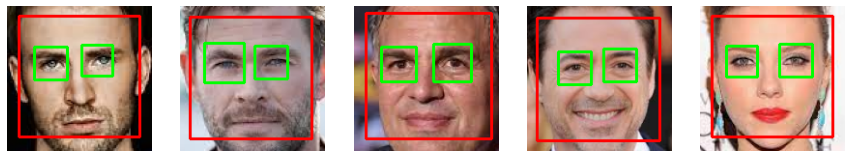

In [21]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_eye.xml") 
#smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_smile.xml")

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3)) # omogućava nam da prilagodimo prikaz rezultata
final_images = []
for index,image in enumerate(images_array):
  # Pronalazimo sva lica na slici
  faces = face_cascade.detectMultiScale(
    cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY),
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
  )
  for (x, y, w, h) in faces:
    final_images.append(cv2.rectangle(image.copy(), (x, y), (x+w, y+h), (0, 0, 255), 2))
    eyes = eye_cascade.detectMultiScale(final_images[index], 1.04, 10) # Pronalazimo oči na slici
    for (ex,ey,ew,eh) in eyes:
      final_images[index] = cv2.rectangle(final_images[index],(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    #smile = smile_cascade.detectMultiScale(final_images[index], 1.38, 6)
    #for (mx,my,mw,mh) in smile:
      #final_images[index] = cv2.rectangle(final_images[index],(mx,my),(mx+mw,my+mh),(0,0,0),2)
  
  ax[index].imshow(cv2.cvtColor(final_images[index], cv2.COLOR_BGR2RGB))
  ax[index].axis('off')
plt.show()



## Detekcija lica pomoću HOG karakteristika

HOG je jednostavan i moćan deskriptor karakteristika. Ne koristi se samo za detekciju lica, već se koristi i za detekciju objekata poput automobila, kućnih ljubimaca i voća. HOG je robustan za detekciju objekata jer se oblik objekta karakterizira korištenjem lokalne raspodjele gradijenta intenziteta i smjera ruba.

Ideja HOG deskriptora je da kreira vektor karakteristika tako da se vektor može ubaciti u klasifikacioni algoritam kao što je SVM da bi se predvideo rezultat. da bismo izračunali HOG deskriptor moramo izračunati gradijente x-ose i y-ose koristeći Sobel kernel.

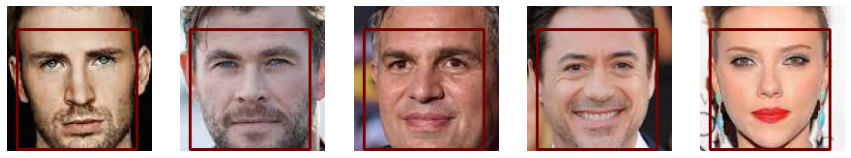

In [22]:
hog_detector = dlib.get_frontal_face_detector() # inicializujemo detektor
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
final_images = []
for index,image in enumerate(images_array):
  faces = hog_detector(image.copy(), 0) # pronalazimo lica na slici
  for face in faces:
    left,top,right,bottom =  face.left(), face.top(), face.right(), face.bottom()
    final_images.append(cv2.rectangle(image.copy(),(left, top),(right, bottom),(0,0,115),2))
  ax[index].imshow(cv2.cvtColor(final_images[index], cv2.COLOR_BGR2RGB))
  ax[index].axis('off')
plt.show() # prikaz



##Detekcija lica pomoću MTCNN

Multi-task Cascaded Convolutional Networks (MTCNN) je okvir razvijen kao rješenje i za detekciju lica i za poravnavanje lica. Proces se sastoji od tri faze konvolucionih mreža koje su u stanju da prepoznaju lica i orijentirne lokacije kao što su oči, nos i usta.

Mreža koristi kaskadnu strukturu sa tri mreže. Prvo se fotografija preska na opseg različitih veličina (naziva se piramida fotografije), zatim prvi model (P-Net) predlaže regione lica kandidata, dok drugi model (R-Net) filtrira bounding box-ove, a treći model (Output Network ili O-Net) predlaže landmarks.

Model se naziva multi-task mrežom jer svaki od tri modela kaskade (P-Net, R-Net i O-Net) se obučavaju na tri zadatka, poput tri tipa predikcija: klasifikacija lica, regresija bounding box-ova i lokalizacija landmarks lica. Ovi modeli nisu direktno povezani - izlaz jedne faze je ulaz u narednu fazu što omogućava dodatnu obradu između faza.

Funkcija MTCNN() iz mtcnn modula biblioteke mtcnn, korišćena je za stvaranje detektora.

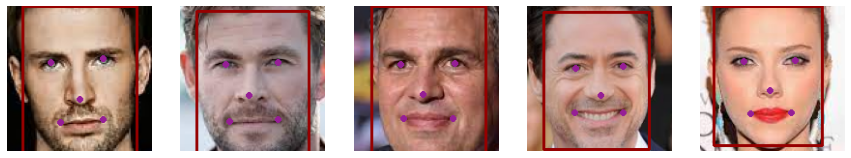

In [23]:
detector = MTCNN() # inicializacija detektora

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
final_images = []

for index,image in enumerate(images_array):
  faces = detector.detect_faces(image.copy()) # detekcija lica na slici
  for face in faces:
    x, y, w, h = face['box']
    final_images.append(cv2.rectangle(image.copy(), (x, y), (x+w, y+h), (0, 0, 150), 2))
    for key, value in face['keypoints'].items(): # detekcija ključnih tačaka
      final_images[index] = cv2.circle(final_images[index],value, 2, (150, 30, 150), 2)
  ax[index].imshow(cv2.cvtColor(final_images[index], cv2.COLOR_BGR2RGB))
  ax[index].axis('off')

plt.show()



##Zaključak

U ovom radu obrađenja i primjenjena tri modela prepoznavanja odnosno detekcije lica. Pored ovih postoji još metoda i načina za detekciju lica i njegovih elementa koje ovde nismo obradili. Primjere je MMOD CNN koji se takođe zasniva na blib biblioteci.
Kao što se da vidjeti iz obrađenih primjera, sa veoma malo koda možemo detektovati lice i njegove ključne tačke. Postoji niz sledećih koraka koje bi smo mogli preduzeti kao što su treniranje modela da prepozna osjećanje, godine ili bi mogli raditi analizu i utvrditi koji od primjenjenih modela daje najtačnije rezultate i koji je najefikasniji. 

Mora se naravno napomenuti i da je dati dataset bio prilagođen potrebi detekcije lica, te je samo uz male modifikacije bio oličan za primjenjene metode detekcije lica. 

Na kraju možemo reći da smo mi u ovom radu samo zagrabli površinu. Mnogo više truda je neophodno kako bi se ovi modeli mogli prilagoti i ubaciti u softver kojem bi oni značili i čiji bi ovi modeli bili glavna funkcionalnost. Naravno, uvijek treba početi od definicije i širiti znanje, pa tako i sa ovim radom. 

## Reference


1.  https://pyimagesearch.com/2021/04/19/face-detection-with-dlib-hog-and-cnn/
2.  https://medium.com/mlcrunch/face-detection-using-dlib-hog-198414837945
3. https://sabbir.dev/article/face-detection-with-opencv-haar-cascade-vs-dlib-hog/
https://towardsdatascience.com/
4. https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49
5. https://medium.com/@iselagradilla94/multi-task-cascaded-convolutional-networks-mtcnn-for-face-detection-and-facial-landmark-alignment-7c21e8007923
6.Materijali sa vježbi, vježbe 11 i 12. 
